<a href="https://colab.research.google.com/github/emiliodallatorre/unive-ct0570-python/blob/main/Classifica_MNIST_con_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione dataset MNIST con TensorFlow

Lo scopo di questo notebook è quello di testare la classificazione del dataset MNIST tramite TensorFlow e non `scikit-learn`.

In primo luogo carichiamo il datasaet MNIST dall'archivio di dataset di TensorFlow.

In [31]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model, Sequential

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

L'obiettivo, adesso, è quello di ripulire le immagini e adeguarle ad un formato adeguato a permettere un'analisi veloce / efficiente.

Costruiamo un batch per fare il training della NN, ovvero uno split del dataset per fare solo questo.

In [25]:
def normalize_image(image, label) -> tuple[tf.Tensor, str]:
  """Converte le immagini da uint8 a float32, più piccolo."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

Costruiamo ora un dataset che permetta di fare testing e assessment della performance di classificazione della NN.

In [26]:
ds_test = ds_test.map(
    normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Addestramento e test del modello

A questo punto, creiamo il modello e lo addestriamo, in modo da vedere le sue performance nel clustering del dataset.

Utilizziamo una classica [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) come funzione di attivazione del neurone che permette di introdurre un po' di non-linearità nel modello.

Una cosa interessante di TensorFlow è creare un modello di livelli che si sovrappongono in maniera molto ordinata.
`Sequential`, per esempio, ci permette di mettere in coda una serie di strati che si occupano di agire sui dati.
Qui usiamo [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) e [Dense](keras.io/api/layers/core_layers/dense/), che si occupano - rispettivamente - di implementare e di implementare il classico livello ben connesso della NN.

In [27]:
model: Model = Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=24,
    validation_data=ds_test,
)

Epoch 1/24
469/469 [==============================] - 7s 5ms/step - loss: 0.3563 - sparse_categorical_accuracy: 0.9016 - val_loss: 0.1904 - val_sparse_categorical_accuracy: 0.9463
Epoch 2/24
469/469 [==============================] - 2s 3ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.9537 - val_loss: 0.1368 - val_sparse_categorical_accuracy: 0.9605
Epoch 3/24
469/469 [==============================] - 2s 3ms/step - loss: 0.1208 - sparse_categorical_accuracy: 0.9648 - val_loss: 0.1109 - val_sparse_categorical_accuracy: 0.9678
Epoch 4/24
469/469 [==============================] - 1s 3ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.1060 - val_sparse_categorical_accuracy: 0.9687
Epoch 5/24
469/469 [==============================] - 2s 3ms/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9782 - val_loss: 0.0844 - val_sparse_categorical_accuracy: 0.9749
Epoch 6/24
469/469 [==============================] - 2s 3ms/step - loss: 0.0627 - sparse_categorica

Osserviamo la performance del modello analizzando i risultati delle varie epoch di training che abbiamo lanciato nello scorso blocco.

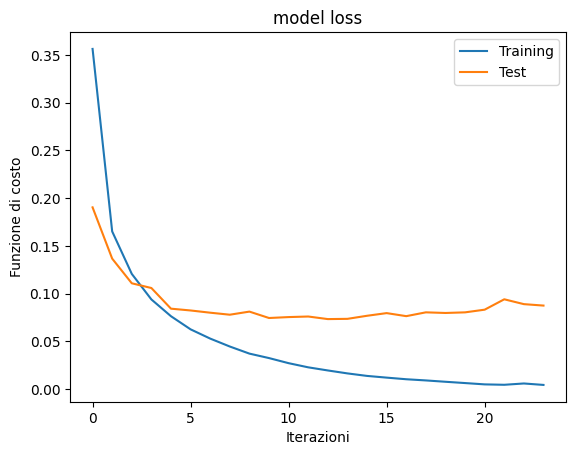

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('Funzione di costo')
plt.xlabel('Iterazioni')
plt.legend(['Training', 'Test'], loc='upper right')

plt.show()

Si vede subito che il decadimento della funzione di costo è antiesponenziale e tende a 0 dato un numero di iterazioni non fissato.

I risultati del modello sul dataset di test ci mostrano evidentemente che dopo la sesta si comincia a veder ricrescere la funzione di costo: si tratta di *overfitting*.